In [ ]:
from kan import *
import pandas as pd
import torch
import numpy as np
torch.set_default_dtype(torch.float64)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

from sklearn.preprocessing import StandardScaler, label_binarize
import matplotlib.pyplot as plt 

X_columns = [
    'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 
    # 'Drate',
    # 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number',
    # 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count',
    # 'syn_count', 'fin_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
    # 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IGMP', 
    'IPv','LLC', 
    'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
    'Magnitue', 'Radius', 'Covariance',
    # 'Variance', 'Weight'
]

# Read the CSV file
train_df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/6classes/6classes_30k_train.csv')
test_df = pd.read_csv('/home/zyang44/Github/baseline_cicIOT/CIC_IoMT/6classes/6classes_3k_test.csv')
label_mapping = {'ARP_Spoofing': 0, 'Benign': 1, 'MQTT': 2, 'Recon': 3, 'TCP_IP-DDOS': 4, 'TCP_IP-DOS': 5}
train_df['label'] = train_df['label'].map(label_mapping)
test_df['label'] = test_df['label'].map(label_mapping)

# 使用 StandardScaler 对数据进行缩放
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_df)
test_data_scaled = scaler.transform(test_df)


# Convert column names to indices
X_indices = [train_df.columns.get_loc(col) for col in X_columns]

dataset = {
    'train_input': torch.tensor(train_data_scaled[:, X_indices], dtype=torch.float64, device=device),
    'train_label': torch.tensor(train_data_scaled[:, -1:], dtype=torch.float64, device=device),
    'test_input': torch.tensor(test_data_scaled[:, X_indices], dtype=torch.float64, device=device),
    'test_label': torch.tensor(test_data_scaled[:, -1:], dtype=torch.float64, device=device)
}
print(dataset['train_input'].shape, dataset['train_label'].shape)
print(dataset['test_input'].shape, dataset['test_label'].shape)
# random pick 10 from dataset['train_input'] to print
print(dataset['train_input'][:10])

cuda:0
torch.Size([28884, 18]) torch.Size([28884, 1])
torch.Size([3138, 18]) torch.Size([3138, 1])
tensor([[  4.5378,   1.9786,  -0.1628,  -0.2220,  -0.2220,   0.1135,   0.1135,
           1.5914,  -0.0592,   2.3993,   1.0379,   3.2862,   1.5170,   1.4056,
           1.4057,   1.5665,   3.2689,   2.8303],
        [ -0.1141,   1.9786,  -0.1628,  -0.2192,  -0.2192,   0.1135,   0.1135,
           2.9797,  -0.0669,   2.3993,   2.0654,   3.9154,   1.8760,   1.4056,
           1.4057,   2.4566,   3.9122,   4.0159],
        [ -0.3476,  -1.6334,  -2.3453,  -0.2290,  -0.2290, -13.7220, -13.7220,
          -0.4067,  -0.2214,  -0.5024,  -0.3579,  -0.4443,  -0.3594,  -1.4149,
          -1.4148,  -0.4107,  -0.4439,  -0.3297],
        [  2.0173,   0.6613,  -0.8176,  -0.2232,  -0.2232,  -4.0372,  -4.0372,
          -0.1240,  -0.2214,   0.7780,   0.0471,   1.2786,   0.5341,  -1.4149,
          -1.4148,   0.2754,   1.2791,   1.0926],
        [ -0.3476,  -1.6334,  -2.3453,  -0.2290,  -0.2290, -13.7220, 

In [65]:
# Check for NaN or infinite values in dataset
print("NaN values in dataset:", np.isnan(train_data_scaled).any())
print("Infinite values in dataset:", np.isinf(test_data_scaled).any())

NaN values in dataset: False
Infinite values in dataset: False


checkpoint directory created: ./model
saving model version 0.0


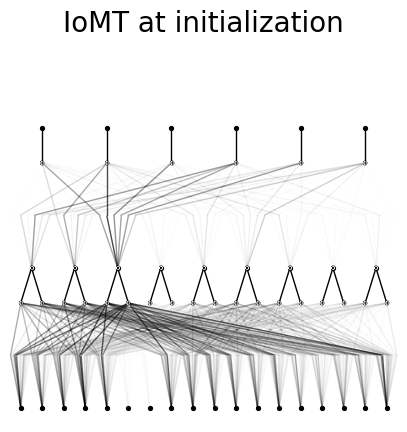

In [66]:
model = KAN(width=[18,[0,9],6], grid=5, k=3, seed=42, device=device)
# plot KAN at initialization
model(dataset['train_input'])
model.plot(title='IoMT at initialization')

| train_loss: 1.91e+01 | test_loss: 1.88e+01 | reg: 1.50e+03 | : 100%|█| 100/100 [00:09<00:00, 10.73


saving model version 0.1


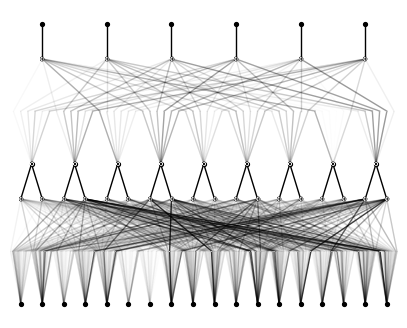

In [67]:
model.fit(dataset, opt="Adam", steps=100, lamb=0.001)
model.plot()

saving model version 0.2


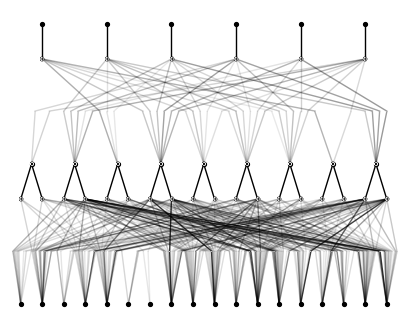

In [68]:
model = model.prune()
model.plot()

| train_loss: 5.75e+01 | test_loss: 5.59e+01 | reg: 1.33e+03 | : 100%|█| 100/100 [00:08<00:00, 12.44


saving model version 0.3


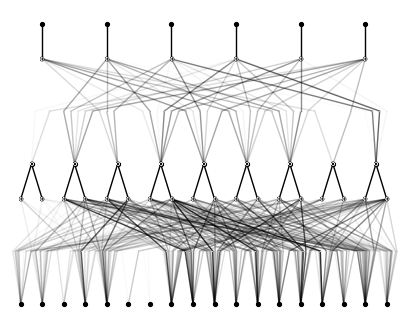

In [69]:
model.fit(dataset, opt="Adam", steps=100)
model.plot()

In [70]:
model.feature_score

tensor([0.4428, 0.4928, 0.1321, 0.7113, 1.0172, 0.0784, 0.0116, 1.1364, 1.2923,
        1.5015, 0.7819, 1.2324, 1.0822, 1.3524, 1.0020, 0.6355, 1.3026, 0.6474],
       device='cuda:0', grad_fn=<MeanBackward1>)

tensor([0.0097, 0.0446, 0.0000, 0.0390, 0.1233, 0.1108, 0.0165, 0.1378, 0.0150,
        0.0273, 0.1341, 0.4412, 0.0026, 0.0990, 0.1282, 0.0515],
       device='cuda:0', grad_fn=<SelectBackward0>)

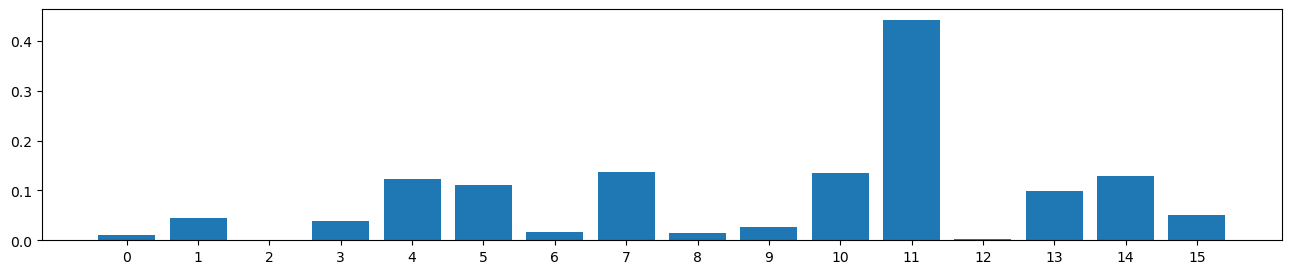

In [80]:
model.attribute(1,5)

keep: [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
saving model version 0.5


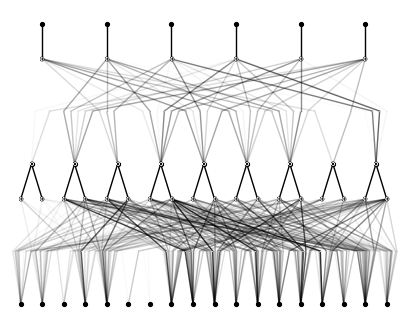

In [74]:
input_vars = ['HLen', 'Pro', 'Dur', 'Rate', 'Srate']
model = model.prune_input()
model.plot()

Text(0, 0.5, 'feature attribution score')

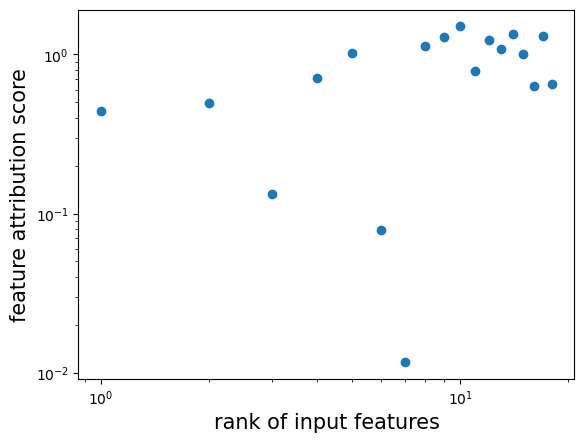

In [77]:
plt.scatter(np.arange(len(X_columns))+1, model.feature_score.cpu().detach().numpy())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('rank of input features', fontsize=15)
plt.ylabel('feature attribution score', fontsize=15)

In [78]:
model = model.prune_input(threshold=0.1)

keep: [True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, True, True, True]
saving model version 0.6
